# Project Scope

## Music Genre Classifier using CNN

### Siu Fung, Chan 101427740, Zifeng Chen 101411338

The importance of music in people's lives is undeniable, and it is typically experienced through sound. However, there is a question of whether we can use a visual approach to classify different music genres. Can we use features such as spectrograms and Mel-frequency cepstral coefficients (MFCCs) to predict the genre of music?

Spectrograms are visual representations of the frequency spectrum of a signal over time. They are commonly used in audio analysis to identify the different frequency components of a sound. MFCCs are another widely used feature extraction technique in audio signal processing that represent the spectral envelope of a sound signal.

By using these features, it is possible to classify music genres using a visual approach. For example, a neural network can be trained to recognize different music genres by analyzing the spectrograms and MFCCs of the music. The neural network can learn to identify patterns in the features that are characteristic of different music genres, and use those patterns to predict the genre of a new piece of music.

Overall, using visual features such as spectrograms and MFCCs to classify music genres is a promising area of research that has the potential to improve our understanding of music and its role in human experience.

# Project Objective

The objective of this project is to classify 30 sec wav files by genre using a TensorFlow CNN model. The GTZAN dataset can be found here:

https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

MFCC is a feature extraction technique that is commonly used in audio signal processing and speech recognition. It involves mapping the spectrum of short-time frames of audio signals onto the Mel scale, dividing it into triangular frequency bands, computing the log of the energy in each band, and transforming the resulting Mel-frequency spectra into the cepstral domain using a DCT. We believe that it could possibly improve the performance of our model. In this case, we are choosing 13 bands.

# Table of Contents - Please check the outline for more details 

## Flow Chart of our project (Main focus would be 2nd and 3rd State):

### First State:

1. We explore the data.
2. We attempt to convert the audio files into melspectrograms for feature extraction, and use a relatively simple model architecture for classification.
3. However, we find that the results are not satisfactory, with a high degree of overfitting. As a result, we decide to investigate other feature extraction methods for converting the audio files.

### Second State:

1. We use MFCC for feature extraction in our second trial, which results in a significant improvement in accuracy, achieving over 75%.
2. To further improve our results, we apply data augmentation techniques to generate a larger dataset for training.

### Third State:

1. We double our training dataset using pitch-shifting methods and retrain the model.
2. The results are further improved, with accuracy exceeding 90%.

# First State

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform

**Unzip the audio file for the model**

**Take a look into format of the audio file**

In [ ]:
audio_recording="./genres_original/country/country.00050.wav"
data , sr=librosa.load(audio_recording)
print(type(data),type(sr))

<class 'numpy.ndarray'> <class 'int'>


**We use librosa library to load the audio**

In [ ]:
librosa.load(audio_recording, sr=45600)

(array([ 0.04446705,  0.06373049,  0.05768819, ..., -0.13878523,
        -0.11868108, -0.05903753], dtype=float32),
 45600)

**Visualize the audio file in Spectrogram format**

C:\Users\Philip\AppData\Local\Temp\ipykernel_6528\1683234743.py:3: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')


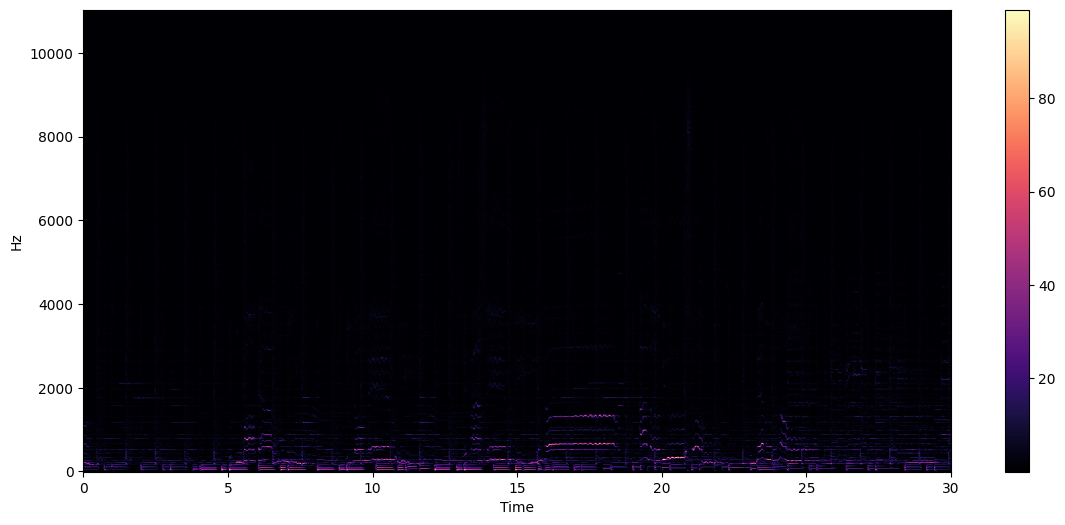

In [ ]:
stft =librosa.stft(data)
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

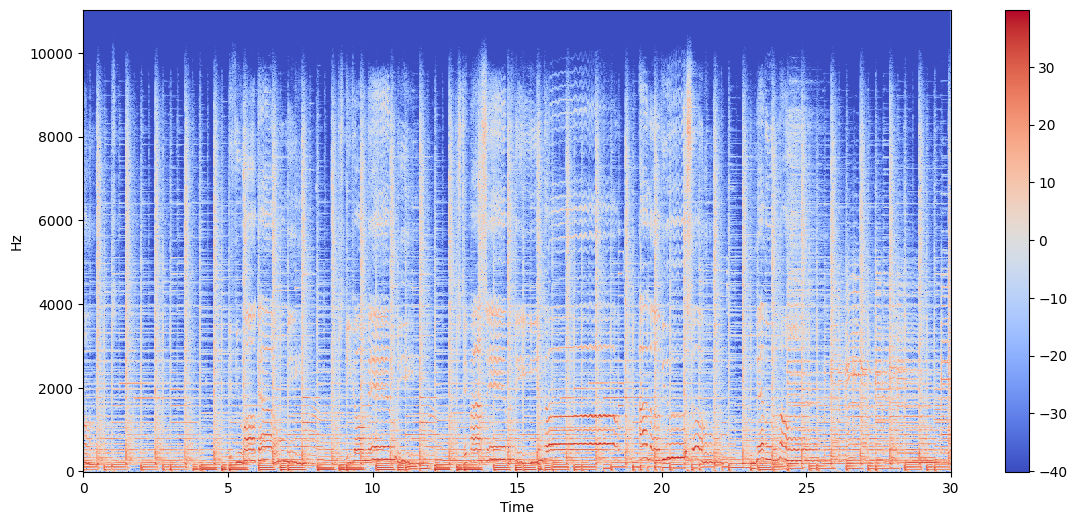

In [ ]:
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

**Here, we use librosa to convert audio to spectrogram, then we use os to create folder and split it. At first, we split it to 70% train set, 20% test set, and 10% validation set. We found that the validation accuracy was very low. Small amount of validation images maybe the possible reason (around 10 images for each class), therefore, we split it as 70% train set and 30% test set to see the result.**

In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
data_path = 'genres_original'

output_folders = ['train', 'test']

for folder in output_folders:
    for genre in genres:
        genre_path = os.path.join(folder, genre)
        if not os.path.exists(genre_path):
            os.makedirs(genre_path)

for genre in genres:
    print(f'Processing genre: {genre}')
    genre_path = os.path.join(data_path, genre)
    for filename in os.listdir(genre_path):
        file_path = os.path.join(genre_path, filename)
        y, sr = librosa.load(file_path, mono=True, duration=30)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        rand_num = np.random.rand()
        if rand_num < 0.3:
            folder = output_folders[1] # 30% testing
        else:
            folder = output_folders[0] # 70% training

        output_path = os.path.join(folder, genre, f'{filename[:-4]}.jpg')
        plt.figure(figsize=(10, 5))
        plt.imshow(mel_spec_db, cmap='Reds', origin='lower', aspect='auto', vmin=mel_spec_db.min(), vmax=mel_spec_db.max())
        plt.axis('off')
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.clf()

print('Done generating spectrograms.')

In [ ]:
train_dir = "./train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(775,385),color_mode="rgba",class_mode='categorical',batch_size=64)

test_dir = "./test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(775,385),color_mode="rgba",class_mode='categorical',batch_size=64)

Found 686 images belonging to 10 classes.
Found 313 images belonging to 10 classes.


**This is the function we take from keras, it calculates F1 score for a binary classification problem. The F1 score is a measure of a model’s accuracy that considers both precision and recall. The function calculates true positives, possible positives, and predicted positives using Keras backend functions and then calculates precision, recall, and F1 score.**

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

**We define the genre model, at first we had cnn and dense layers, we also found that the result was not well, and using deep neural network may also be one of the reasons causing overfitting, therefore, we reduce the layers of the network and see what happen.**

In [ ]:
def GenreModel(input_shape=(775, 385, 4), classes=10, learning_rate=0.001, optimizer='adam'):
    X_input = Input(input_shape)

    X = Conv2D(8, kernel_size=(3,3), strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Flatten()(X)
  
    X = Dropout(rate=0.4)(X)

    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    model = Model(inputs=X_input, outputs=X, name='GenreModel')
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', get_f1])
    model = model.fit_generator(train_generator,validation_data=test_generator, epochs = 10)
    
    return model

**As you can see, even we increased the sample size of the testing set and reduce the number of layers, the validation result was still low. We think that it could be something wrong when we preprocess our data, so we decided to use another method called MFCCs instead of spectrogram.**

In [ ]:
learning_rates = [0.005, 0.001]
model_pool = []

for lr in learning_rates:
  optimizers = [tf.keras.optimizers.legacy.Adam(lr), tf.keras.optimizers.legacy.Nadam(lr), tf.keras.optimizers.legacy.RMSprop(lr)]
  for op in optimizers:
    model_pool.append(GenreModel(input_shape=(775, 385, 4), classes=10))
    print(f"learning_rate: {lr}, optimizer: {op}")

<ipython-input-6-dc5f5147b7d5>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model = model.fit_generator(train_generator,validation_data=test_generator, epochs = 10)


Epoch 1/10
11/11 [==============================] - 29s 2s/step - loss: 228.7953 - accuracy: 0.1793 - get_f1: 0.1749 - val_loss: 186.7672 - val_accuracy: 0.1597 - val_get_f1: 0.1601
Epoch 2/10
11/11 [==============================] - 19s 2s/step - loss: 104.3269 - accuracy: 0.4096 - get_f1: 0.4092 - val_loss: 164.7766 - val_accuracy: 0.1949 - val_get_f1: 0.1952
Epoch 3/10
11/11 [==============================] - 15s 1s/step - loss: 49.5790 - accuracy: 0.4577 - get_f1: 0.4532 - val_loss: 192.0739 - val_accuracy: 0.1022 - val_get_f1: 0.1027
Epoch 4/10
11/11 [==============================] - 16s 2s/step - loss: 17.0421 - accuracy: 0.6574 - get_f1: 0.6567 - val_loss: 177.8080 - val_accuracy: 0.1022 - val_get_f1: 0.1027
Epoch 5/10
11/11 [==============================] - 20s 2s/step - loss: 10.3657 - accuracy: 0.7026 - get_f1: 0.6997 - val_loss: 148.5986 - val_accuracy: 0.1022 - val_get_f1: 0.1008
Epoch 6/10
11/11 [==============================] - 17s 2s/step - loss: 5.4172 - accuracy: 0.

# Functions for Second and Third State

### Load Library

In [1]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#APT is a package manager for Debian and Ubuntu-based Linux distributions. Installing FFmpeg on Windows is quite complicated, so we recommend to use Colab to execute the code
!apt install -y ffmpeg
#pysoundfile is extra for the function of loading 
!pip install pysoundfile

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load zip file into google CoLab

In [ ]:
!unzip /content/drive/MyDrive/train.zip -d /content/

In [5]:
# Dataset location
SOURCE_PATH = '/content/genres_original'

# Path to labels and processed data file, json format.
JSON_PATH = 'data.json'

# Sampling rate. Sample rate in audio refers to the number of samples of audio captured per second. It is also known as the sampling frequency, and is measured in Hertz (Hz). The sample rate determines the resolution of the digital representation of an analog audio signal, and is a critical factor in digital audio quality.
sr = 22050

# Let's make sure all files have the same amount of samples, pick a duration right under 30 seconds.
TOTAL_SAMPLES = 29 * sr

# The dataset contains 999 files. Lets make it bigger. 
# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

### Data preprocessing 

This function iterates over all the audio files contained within the specified directories. For each audio file, it loads the file using a music analysis library to extract the features, computes the Mel-Frequency Cepstral Coefficients (MFCCs) of the audio signal, and stores the MFCCs along with the corresponding label into a JSON file. The resulting JSON file can be used as a preprocessed dataset for a machine learning model.

In [6]:
import soundfile as sf
def preprocess_data(source_path, json_path):

    # Let's create a dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Let's browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        print("i=", i)
        print("dirpath=", dirpath)
        print("dirnames=", dirnames)
        for file in filenames:
            song, sr = sf.read(os.path.join(dirpath, file), dtype='float32')
            if song.ndim > 1:
                song = song.mean(axis=1)  # convert stereo to mono
            else:
                song = song.squeeze()

            for s in range(NUM_SLICES):
                start_sample = SAMPLES_PER_SLICE * s
                end_sample = start_sample + SAMPLES_PER_SLICE
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                mfcc = mfcc.T
                mydict["labels"].append(i-1)
                mydict["mfcc"].append(mfcc.tolist())

    # Let's write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

### Load data

This code reads the previously stored data in JSON format, which contains the Mel-Frequency Cepstral Coefficients (MFCCs) and corresponding labels for a set of audio files. It then converts this data into a format suitable for training a machine learning model, by splitting it into separate arrays X and y. The array X contains the MFCCs for each audio file, while the array y contains the corresponding labels. These arrays can be used as inputs to a machine learning model for music genre classification.

In [7]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print(X.shape)

    return X, y

### Prepare datasets 

The inputs and targets are split using the train_test_split function from the scikit-learn library. The split_size parameter specifies the 0.2 of the validation and test sets as a fraction of the input data.

After splitting the data, the function adds a new axis to the input data to convert it to 3D shape for the CNN model.

In [8]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

### Model Architecture

In [9]:
def design_model(input_shape):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

### Make_prediction

This function is build to test the classification model for a single audio files. 

In [10]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

### Plot performance

It plot the accuracy and loss against epoches for training and vaildation, which is important for evaluate or further improvement for the model. 

In [11]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [12]:
# delete some problem file while running in colab
!rmdir /content/genres_original/jazz/.ipynb_checkpoints
!rm /content/genres_original/jazz/jazz.00054.wav

rmdir: failed to remove '/content/genres_original/jazz/.ipynb_checkpoints': No such file or directory


### Visualize the MFCC data

In [13]:
def vis_mfcc(x, y):

    visualize_mcff = np.squeeze(x)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(visualize_mcff, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()
    print(y)

# Second State: Main Part of the code (Before argumentation)

i= 0
dirpath= /content/genres_original
dirnames= ['hiphop', 'jazz', 'classical', 'disco', 'reggae', 'country', 'rock', 'metal', 'blues', 'pop']
i= 1
dirpath= /content/genres_original/hiphop
dirnames= []
i= 2
dirpath= /content/genres_original/jazz
dirnames= []
i= 3
dirpath= /content/genres_original/classical
dirnames= []
i= 4
dirpath= /content/genres_original/disco
dirnames= []
i= 5
dirpath= /content/genres_original/reggae
dirnames= []
i= 6
dirpath= /content/genres_original/country
dirnames= []
i= 7
dirpath= /content/genres_original/rock
dirnames= []
i= 8
dirpath= /content/genres_original/metal
dirnames= []
i= 9
dirpath= /content/genres_original/blues
dirnames= []
i= 10
dirpath= /content/genres_original/pop
dirnames= []
(9990, 125, 13)


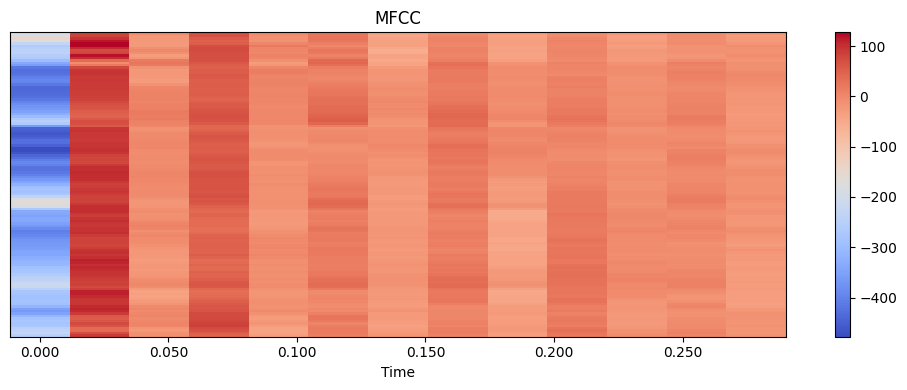

6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                                      

In [14]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
inputs, targets = load_data(json_path=JSON_PATH)
    
Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

vis_mfcc(Xtrain[0], ytrain[0])

input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)

model = design_model(input_shape)

# Selection of the optimizer, loss type and metrics for performance evaluation.
model.compile(optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics = ['acc']
                  )

model.summary()



## Model Training

In [15]:
# Training the model.
history = model.fit(Xtrain, ytrain,
                    validation_data=(Xval, yval),
                    epochs=30,
                    batch_size=32
                    )



Epoch 1/30
200/200 [==============================] - 12s 55ms/step - loss: 1.5472 - acc: 0.4599 - val_loss: 1.3869 - val_acc: 0.4905
Epoch 2/30
200/200 [==============================] - 10s 49ms/step - loss: 1.1238 - acc: 0.6005 - val_loss: 1.4050 - val_acc: 0.5285
Epoch 3/30
200/200 [==============================] - 10s 51ms/step - loss: 0.9751 - acc: 0.6598 - val_loss: 1.0082 - val_acc: 0.6466
Epoch 4/30
200/200 [==============================] - 11s 53ms/step - loss: 0.8731 - acc: 0.6915 - val_loss: 0.9748 - val_acc: 0.6426
Epoch 5/30
200/200 [==============================] - 11s 53ms/step - loss: 0.7882 - acc: 0.7170 - val_loss: 0.8281 - val_acc: 0.7142
Epoch 6/30
200/200 [==============================] - 11s 53ms/step - loss: 0.7257 - acc: 0.7477 - val_loss: 0.8357 - val_acc: 0.6987
Epoch 7/30
200/200 [==============================] - 9s 47ms/step - loss: 0.6711 - acc: 0.7599 - val_loss: 0.7598 - val_acc: 0.7307
Epoch 8/30
200/200 [==============================] - 11s 54ms/

## Model Evaluation

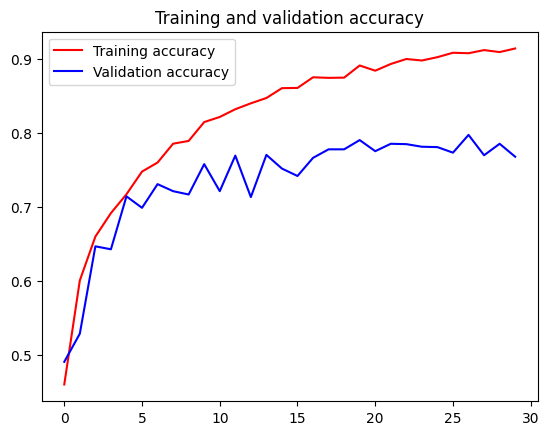

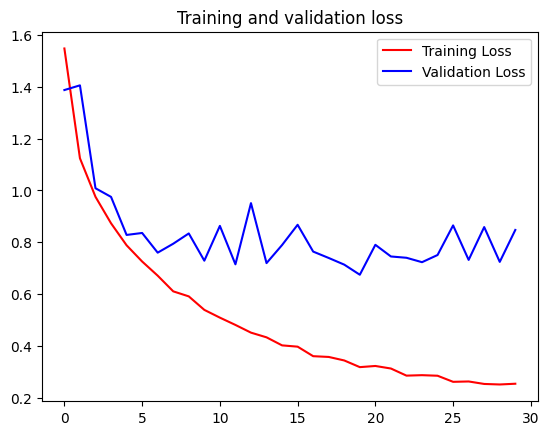

50/50 [==============================] - 1s 15ms/step

---Now testing the model for one audio file---
The model predicts: metal, and ground truth is: metal.



In [16]:
plot_performance(history)

# Testing the model on never seen before data.
make_prediction(model, Xtest, ytest, 24)

In [22]:
from sklearn.metrics import f1_score , accuracy_score
pred = model.predict(Xtest)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(ytest,preds,average='micro')
accuracy = accuracy_score(ytest,preds)

50/50 [==============================] - 1s 24ms/step


In [23]:
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")

The Test Accuracy is 0.776735459662289 
 The F1 Score is 0.776735459662289


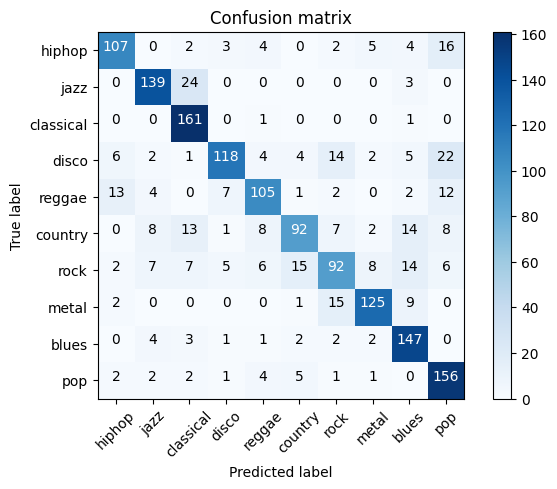

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest,preds)
classes= ['hiphop', 'jazz', 'classical', 'disco', 'reggae', 'country', 'rock', 'metal', 'blues', 'pop']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Third State: Main Part of the code (After argumentation)

Data augmentation - time stretching

Time stretching: This involves changing the tempo of the music without altering the pitch, which can help increase the variability in the data. It can be implemented using the librosa.effects.time_stretch() function in the librosa library.

In [17]:
def data_augmentation(source_path, json_path):
    # Define constants
    NUM_SLICES = 10
    SAMPLES_PER_SLICE = 22050 // NUM_SLICES

    # Define the pitch factor
    pitch_factor = 2

    # Let's browse each file, slice it, time stretch it, and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        print("i=", i)
        print("dirpath=", dirpath)
        print("dirnames=", dirnames)
        for file in filenames:
            # Load the audio file
            audio_file = os.path.join(dirpath, file)
            y, sr = librosa.load(audio_file)

            # Slice and time stretch the audio
            shifted_data = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_factor)

            # Save the stretched audio file with original name plus "_stretched"
            out_file = os.path.splitext(file)[0] + '_shifted' + os.path.splitext(file)[1]
            out_path = os.path.join(dirpath, out_file)
            sf.write(out_path, shifted_data, sr)

In [18]:
data_augmentation(source_path=SOURCE_PATH, json_path=JSON_PATH)

i= 0
dirpath= /content/genres_original
dirnames= ['hiphop', 'jazz', 'classical', 'disco', 'reggae', 'country', 'rock', 'metal', 'blues', 'pop']
i= 1
dirpath= /content/genres_original/hiphop
dirnames= []
i= 2
dirpath= /content/genres_original/jazz
dirnames= []
i= 3
dirpath= /content/genres_original/classical
dirnames= []
i= 4
dirpath= /content/genres_original/disco
dirnames= []
i= 5
dirpath= /content/genres_original/reggae
dirnames= []
i= 6
dirpath= /content/genres_original/country
dirnames= []
i= 7
dirpath= /content/genres_original/rock
dirnames= []
i= 8
dirpath= /content/genres_original/metal
dirnames= []
i= 9
dirpath= /content/genres_original/blues
dirnames= []
i= 10
dirpath= /content/genres_original/pop
dirnames= []


i= 0
dirpath= /content/genres_original
dirnames= ['hiphop', 'jazz', 'classical', 'disco', 'reggae', 'country', 'rock', 'metal', 'blues', 'pop']
i= 1
dirpath= /content/genres_original/hiphop
dirnames= []
i= 2
dirpath= /content/genres_original/jazz
dirnames= []
i= 3
dirpath= /content/genres_original/classical
dirnames= []
i= 4
dirpath= /content/genres_original/disco
dirnames= []
i= 5
dirpath= /content/genres_original/reggae
dirnames= []
i= 6
dirpath= /content/genres_original/country
dirnames= []
i= 7
dirpath= /content/genres_original/rock
dirnames= []
i= 8
dirpath= /content/genres_original/metal
dirnames= []
i= 9
dirpath= /content/genres_original/blues
dirnames= []
i= 10
dirpath= /content/genres_original/pop
dirnames= []
(19980, 125, 13)


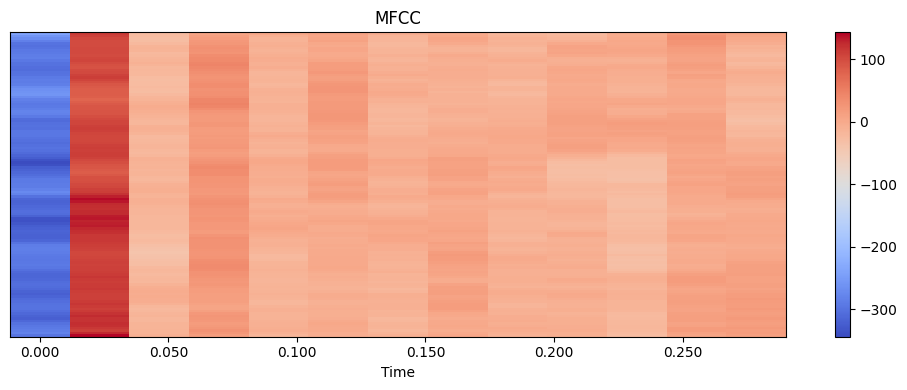

2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 62, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                                    

In [19]:
JSON_PATH = 'data_shifted.json'

preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
inputs, targets = load_data(json_path=JSON_PATH)
    
Xtrain_shifted, Xval_shifted, Xtest_shifted, ytrain_shifted, yval_shifted, ytest_shifted = prepare_datasets(inputs, targets, 0.2)

vis_mfcc(Xtrain_shifted[0], ytrain_shifted[0])

input_shape_shifted = (Xtrain_shifted.shape[1], Xtrain_shifted.shape[2], 1)

model_shifted = design_model(input_shape_shifted)

# Selection of the optimizer, loss type and metrics for performance evaluation.
model_shifted.compile(optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics = ['acc']
                  )

model_shifted.summary()


## Model Training

In [20]:
# Training the model.
history_shifted = model_shifted.fit(Xtrain_shifted, ytrain_shifted,
                    validation_data=(Xval, yval),
                    epochs=30,
                    batch_size=32
                    )


Epoch 1/30
400/400 [==============================] - 22s 54ms/step - loss: 1.4970 - acc: 0.4689 - val_loss: 1.1904 - val_acc: 0.5676
Epoch 2/30
400/400 [==============================] - 21s 52ms/step - loss: 1.1069 - acc: 0.6112 - val_loss: 1.2636 - val_acc: 0.5380
Epoch 3/30
400/400 [==============================] - 20s 51ms/step - loss: 0.9275 - acc: 0.6682 - val_loss: 0.8275 - val_acc: 0.7087
Epoch 4/30
400/400 [==============================] - 21s 54ms/step - loss: 0.8230 - acc: 0.7121 - val_loss: 0.7384 - val_acc: 0.7357
Epoch 5/30
400/400 [==============================] - 20s 50ms/step - loss: 0.7477 - acc: 0.7362 - val_loss: 0.6539 - val_acc: 0.7643
Epoch 6/30
400/400 [==============================] - 22s 55ms/step - loss: 0.6810 - acc: 0.7612 - val_loss: 0.6032 - val_acc: 0.7793
Epoch 7/30
400/400 [==============================] - 20s 50ms/step - loss: 0.6334 - acc: 0.7788 - val_loss: 0.6032 - val_acc: 0.7888
Epoch 8/30
400/400 [==============================] - 21s 53ms

## Model Evaluation

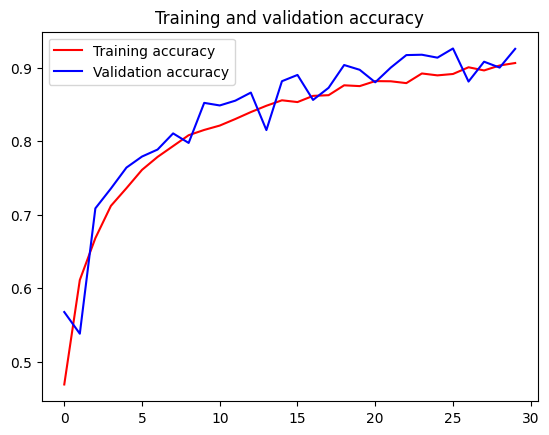

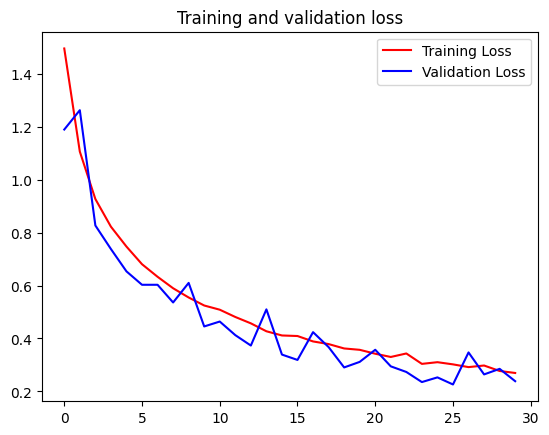

50/50 [==============================] - 1s 12ms/step

---Now testing the model for one audio file---
The model predicts: metal, and ground truth is: metal.



In [21]:
plot_performance(history_shifted)

# Testing the model on never seen before data.
make_prediction(model_shifted, Xtest, ytest, 24)

In [25]:
from sklearn.metrics import f1_score , accuracy_score
pred = model_shifted.predict(Xtest)
preds = []
for i in pred:
    out = np.argmax(i)
    preds.append(out)
f1score = f1_score(ytest,preds,average='micro')
accuracy = accuracy_score(ytest,preds)

50/50 [==============================] - 1s 15ms/step


In [26]:
print(f"The Test Accuracy is {accuracy} \n The F1 Score is {f1score}")

The Test Accuracy is 0.9224515322076298 
 The F1 Score is 0.9224515322076298


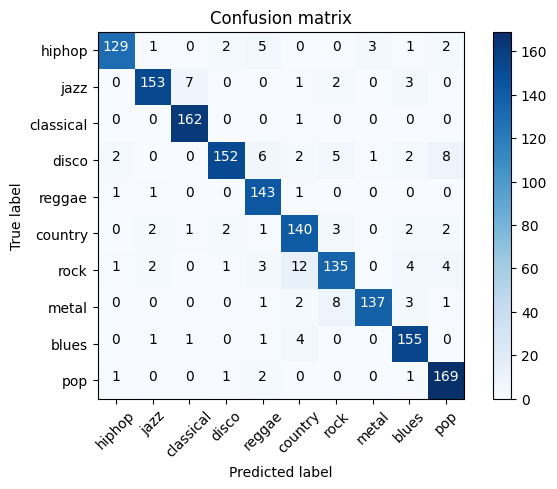

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest,preds)
classes= ['hiphop', 'jazz', 'classical', 'disco', 'reggae', 'country', 'rock', 'metal', 'blues', 'pop']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()